### imports

In [1]:
import numpy as np
import pandas as pd
import os
import re
import pickle
from string import digits
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import entropy, pearsonr, ttest_1samp
from scipy.spatial.distance import cdist
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import hypertools as hyp

%matplotlib inline
sns.set_context('talk')

### paths

In [2]:
vid_transc_dir = '../video transcript analysis'
answers_dir = '../graded_answers/'
figdir = '../../figures/'

### functions

In [3]:
def model_lessons_questions(v_windows, q_windows, vec_params, lda_params):
    """
    Fit a topic model to video and question content, use it to transform videos and questions.
    Returns a tuple: (video topic proportions, question topic proportions, fit topic model)
    """
    
    # initialize count vectorizer
    tf_vectorizer = CountVectorizer(**vec_params)
    # fit the model
    tf_vectorizer.fit(v_windows+q_windows)

    # transform video windows
    video_tf = tf_vectorizer.transform(v_windows)

    # transform question samples
    questions_tf = tf_vectorizer.transform(q_windows)

    both_tf = tf_vectorizer.transform(v_windows+q_windows)

    # initialize topic model
    lda = LatentDirichletAllocation(**lda_params)

    # fit topic model to video and questions
    lda.fit(both_tf)

    # transform video
    video_topics = lda.transform(video_tf)

    # smooth video model
    video_topics = pd.DataFrame(video_topics).rolling(25).mean().loc[25:,:].values

    # transform questions
    questions_topics = lda.transform(questions_tf)
    
    return video_topics, questions_topics, lda


In [4]:
def reconstruct_trace(video_model, questions_model, acc):
    """
    Function that reconstructs memory trajectory based on video model and a set of correctly answered questions
    """
    
    def normalize(x):
        xs = x - np.min(x)
        return np.divide(xs, np.max(xs))
    
    def z2r(z):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
    
    def r2z(r):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
    
    def symmetric_KL(a, b, c=.00000000001):
        return np.divide(entropy(a+c,b+c)+entropy(b+c,a+c), 2)

    # compute timepoints by questions correlation matrix
    wz = 1-cdist(video_model, questions_model, symmetric_KL)
    
    # add the minimum value
    wz-=np.min(wz)
    
    # divide by the max value
    wz/=np.max(wz)
    
    # sum over columns
    a = np.sum(wz, axis=1)
 
    # sum over columns for correct answers
    b = np.sum(wz[:, list(map(bool, acc))], axis=1)
    
    # divide b by a
    ba = np.array(np.divide(b,a), ndmin=2)
    
    # weight the model
    return video_model*ba.T

In [5]:
def format_text(text):
    """
    Function to format documents for tokenization and modeling
    """
    
    clean_text = []
    
    for sentence in text:
        no_punc = re.sub("[^a-zA-Z\s']+", '', sentence.lower())
        no_stop = ' '.join([word for word in no_punc.split() if word not in all_stopwords])
        clean = re.sub("'+", '', no_stop)
        clean_text.append(clean)
    
    return clean_text

## load lesson and question data

In [6]:
# Four forces
forces_video_df = pd.read_csv(os.path.join(vid_transc_dir,'fourforcesdiced.tsv'), 
                            error_bad_lines=False, header=None, sep='\t', usecols=[0])
forces_video_samples = forces_video_df[0].tolist()

# birth of stars
bos_video_df = pd.read_csv(os.path.join(vid_transc_dir, 'birthofstarsdiced.tsv'), 
                            error_bad_lines=False, header=None, sep='\t', usecols=[0])
bos_video_samples = pd.Series(bos_video_df[0]).tolist()

In [7]:
# questions
questions_df = pd.read_csv('../data analysis/astronomyquestions.tsv', sep='\t', 
            names=['index', 'video', 'question', 'ans_A', 'ans_B', 'ans_C', 'ans_D'], index_col='index') 

forces_questions_samples = questions_df.loc[questions_df.video == 1].question.tolist()
bos_questions_samples = questions_df.loc[questions_df.video == 2].question.tolist()
general_question_samples = questions_df.loc[questions_df.video == 0].question.tolist()

# link question text to qID
question_dict = {qid : questions_df.loc[qid].question for qid in questions_df.index}

## load and format participant answer data

In [8]:
data_df = pd.read_csv(os.path.join(answers_dir, 'Graded_results_19s.csv'), index_col='Unnamed: 0')

# dictionary format - {participantID : dataframe}
sub_data = dict()

for sub in data_df.participantID.unique():
    sub_data[sub] = data_df.loc[data_df.participantID == sub].drop('participantID', axis=1).reset_index(drop=True)

sub_data[1].head()

,correct?,qID,set,video
0,1,13,0,1
1,0,21,0,2
2,0,12,0,1
3,1,16,0,2
4,1,28,0,2


### topic modeling params

In [9]:
vec_params = {
    'max_df': 0.95,
    'min_df': 2,
    'max_features': 500,
    'stop_words': 'english'
}

lda_params = {
    'n_components': 12,
    'max_iter': 10,
    'learning_method': 'online',
    'learning_offset':50.,
    'random_state': 0
}

In [10]:
all_stopwords = stopwords.words('english') + ["let's", "they'd", "they're", "they've", "they'll", "that's", 
                                              "I'll", "I'm"]

# how does ability to infer knowledge change with topic space distance?

In [11]:
# format lecture and question text
fvs_formatted = format_text(forces_video_samples)
bvs_formatted = format_text(bos_video_samples)
fqs_formatted = format_text(forces_questions_samples)
bqs_formatted = format_text(bos_questions_samples)
gqs_formatted = format_text(general_question_samples)

### model fit to both lectures and all questions

In [12]:
# # initialize count vectorizer
# tf_vectorizer = CountVectorizer(**vec_params)

# # fit to both lectures and all questions
# tf_vectorizer.fit(fvs_formatted + fqs_formatted
#                   + bvs_formatted + bqs_formatted
#                   + gqs_formatted)

# # transform lecture windows
# forces_video_tf = tf_vectorizer.transform(fvs_formatted)
# bos_video_tf = tf_vectorizer.transform(bvs_formatted)

# # transform question samples
# forces_questions_tf = tf_vectorizer.transform(fqs_formatted)
# bos_questions_tf = tf_vectorizer.transform(bqs_formatted)
# general_questions_tf = tf_vectorizer.transform(gqs_formatted)

# all_tf = tf_vectorizer.transform(fvs_formatted + fqs_formatted
#                   + bvs_formatted + bqs_formatted
#                   + gqs_formatted)

# # initialize LDA model, fit to both lectures and all questions
# lda = LatentDirichletAllocation(**lda_params)
# lda.fit(all_tf)

# # transform lectures
# forces_v_traj = lda.transform(forces_video_tf)
# bos_v_traj = lda.transform(bos_video_tf)

# # smooth lecture models
# forces_v_traj = pd.DataFrame(forces_v_traj).rolling(25).mean().loc[25:,:].values
# bos_v_traj = pd.DataFrame(bos_v_traj).rolling(25).mean().loc[25:,:].values

# # transform questions
# forces_q_traj = lda.transform(forces_questions_tf)
# bos_q_traj = lda.transform(bos_questions_tf)
# general_q_traj = lda.transform(general_questions_tf)


### model fit to both lectures and two sets of lecture-related questions

In [13]:
# initialize count vectorizer
tf_vectorizer = CountVectorizer(**vec_params)

# fit to both lectures and all questions
tf_vectorizer.fit(fvs_formatted + fqs_formatted
                  + bvs_formatted + bqs_formatted)

# transform lecture windows
forces_video_tf = tf_vectorizer.transform(fvs_formatted)
bos_video_tf = tf_vectorizer.transform(bvs_formatted)

# transform question samples
forces_questions_tf = tf_vectorizer.transform(fqs_formatted)
bos_questions_tf = tf_vectorizer.transform(bqs_formatted)
general_questions_tf = tf_vectorizer.transform(gqs_formatted)

all_tf = tf_vectorizer.transform(fvs_formatted + fqs_formatted
                  + bvs_formatted + bqs_formatted)

# initialize LDA model, fit to both lectures and all questions
lda = LatentDirichletAllocation(**lda_params)
lda.fit(all_tf)

# transform lectures
forces_v_traj = lda.transform(forces_video_tf)
bos_v_traj = lda.transform(bos_video_tf)

# smooth lecture models
forces_v_traj = pd.DataFrame(forces_v_traj).rolling(25).mean().loc[25:,:].values
bos_v_traj = pd.DataFrame(bos_v_traj).rolling(25).mean().loc[25:,:].values

# transform questions
forces_q_traj = lda.transform(forces_questions_tf)
bos_q_traj = lda.transform(bos_questions_tf)
general_q_traj = lda.transform(general_questions_tf)


### model fit to both lectures (no questions)

In [14]:
# # initialize count vectorizer
# tf_vectorizer = CountVectorizer(**vec_params)

# # fit to both lectures and all questions
# tf_vectorizer.fit(fvs_formatted + bvs_formatted)

# # transform lecture windows
# forces_video_tf = tf_vectorizer.transform(fvs_formatted)
# bos_video_tf = tf_vectorizer.transform(bvs_formatted)

# # transform question samples
# forces_questions_tf = tf_vectorizer.transform(fqs_formatted)
# bos_questions_tf = tf_vectorizer.transform(bqs_formatted)
# general_questions_tf = tf_vectorizer.transform(gqs_formatted)

# videos_tf = tf_vectorizer.transform(fvs_formatted + bvs_formatted)

# # initialize LDA model, fit to both lectures and all questions
# lda = LatentDirichletAllocation(**lda_params)
# lda.fit(videos_tf)

# # transform lectures
# forces_v_traj = lda.transform(forces_video_tf)
# bos_v_traj = lda.transform(bos_video_tf)

# # smooth lecture models
# forces_v_traj = pd.DataFrame(forces_v_traj).rolling(25).mean().loc[25:,:].values
# bos_v_traj = pd.DataFrame(bos_v_traj).rolling(25).mean().loc[25:,:].values

# # transform questions
# forces_q_traj = lda.transform(forces_questions_tf)
# bos_q_traj = lda.transform(bos_questions_tf)
# general_q_traj = lda.transform(general_questions_tf)


## construct held-out-question learning trajectories

In [240]:
qdrop_ftraces_set0 = {}
qdrop_ftraces_set1 = {}
qdrop_ftraces_set2 = {}


for set_n, setdict in zip(range(3), [qdrop_ftraces_set0, qdrop_ftraces_set1, qdrop_ftraces_set2]):
    drops = []
    for sid, df in sub_data.items():
        # get questions about Four Forces viewed in block 
        set_fqs = df.loc[df.set == set_n].loc[df.video == 1]
        setdict[f'sub{sid}'] = dict.fromkeys([f'q{i}' for i in set_fqs.qID])
    
        for q in set_fqs.qID:
            setdict[f'sub{sid}'][f'q{q}'] = {}
            # drop a question
            ix = set_fqs.loc[set_fqs.qID == q].index
            q_dropped = set_fqs.drop(ix)
            
            # extract remaining questions' topic vectors by index
            q_dropped_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in q_dropped.qID]]
            
            # get accuracy for remaining questions
            q_dropped_acc = q_dropped['correct?']

            # construct trace with question held out
            q_dropped_trace = reconstruct_trace(forces_v_traj, q_dropped_vecs, q_dropped_acc)
            setdict[f'sub{sid}'][f'q{q}']['trajectory'] = q_dropped_trace
            
            # get accuracy for held-out question
            setdict[f'sub{sid}'][f'q{q}']['correct'] = set_fqs.loc[ix, 'correct?'].values[0]
            
            # find distance between lecture and knowledge trajectories at nearest lecture point to question
            nearest_ix = cdist(forces_v_traj, np.atleast_2d(forces_q_traj[q-1])).argmin()
            setdict[f'sub{sid}'][f'q{q}']['learn_dist'] = np.diag(cdist(forces_v_traj, q_dropped_trace))[nearest_ix]
            
            # find distance from held-out question to nearest other question
            qq_dists = cdist(forces_q_traj, forces_q_traj)[q-1]
            setdict[f'sub{sid}'][f'q{q}']['qnear_dist'] = qq_dists[np.nonzero(qq_dists)].min()
            
            # track participants with 4/5 wrong answers (can't construct trajectory)
            if not np.any(q_dropped_trace):
                drops.append(f'sub{sid}')
    
    for sid in list(set(drops)):
        del setdict[sid]
                

In [224]:
qdrop_btraces_set0 = {}
qdrop_btraces_set1 = {}
qdrop_btraces_set2 = {}


for set_n, setdict in zip(range(3), [qdrop_btraces_set0, qdrop_btraces_set1, qdrop_btraces_set2]):
    drops = []
    for sid, df in sub_data.items():
        # get questions about Birth of Stars viewed in block 
        set_bqs = df.loc[df.set == set_n].loc[df.video == 2]
        setdict[f'sub{sid}'] = dict.fromkeys([f'q{i}' for i in set_bqs.qID])
    
        for q in set_bqs.qID:
            setdict[f'sub{sid}'][f'q{q}'] = {}
            # drop a question
            ix = set_bqs.loc[set_bqs.qID == q].index
            q_dropped = set_bqs.drop(ix)
            
            # extract remaining questions' topic vectors by index
            q_dropped_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in q_dropped.qID]]
            
            # get accuracy for remaining questions
            q_dropped_acc = q_dropped['correct?']

            # construct trace with question held out
            q_dropped_trace = reconstruct_trace(bos_v_traj, q_dropped_vecs, q_dropped_acc)
            setdict[f'sub{sid}'][f'q{q}']['trajectory'] = q_dropped_trace
            
            # get accuracy for held-out question
            setdict[f'sub{sid}'][f'q{q}']['correct'] = set_bqs.loc[ix, 'correct?'].values[0]
            
            # find distance between lecture and knowledge trajectories at nearest lecture point to question
            nearest_ix = cdist(bos_v_traj, np.atleast_2d(bos_q_traj[q-16])).argmin()
            setdict[f'sub{sid}'][f'q{q}']['learn_dist'] = np.diag(cdist(bos_v_traj, q_dropped_trace))[nearest_ix]
            
            # find distance from held-out question to nearest other question
            qq_dists = cdist(bos_q_traj, bos_q_traj)[q-16]
            setdict[f'sub{sid}'][f'q{q}']['qnear_dist'] = qq_dists[np.nonzero(qq_dists)].min()
            
            # track participants with 4/5 wrong answers (can't construct trajectory)
            if not np.any(q_dropped_trace):
                drops.append(f'sub{sid}')
    
    for sid in list(set(drops)):
        del setdict[sid]
                

# bin lecture-learning trajectory distances

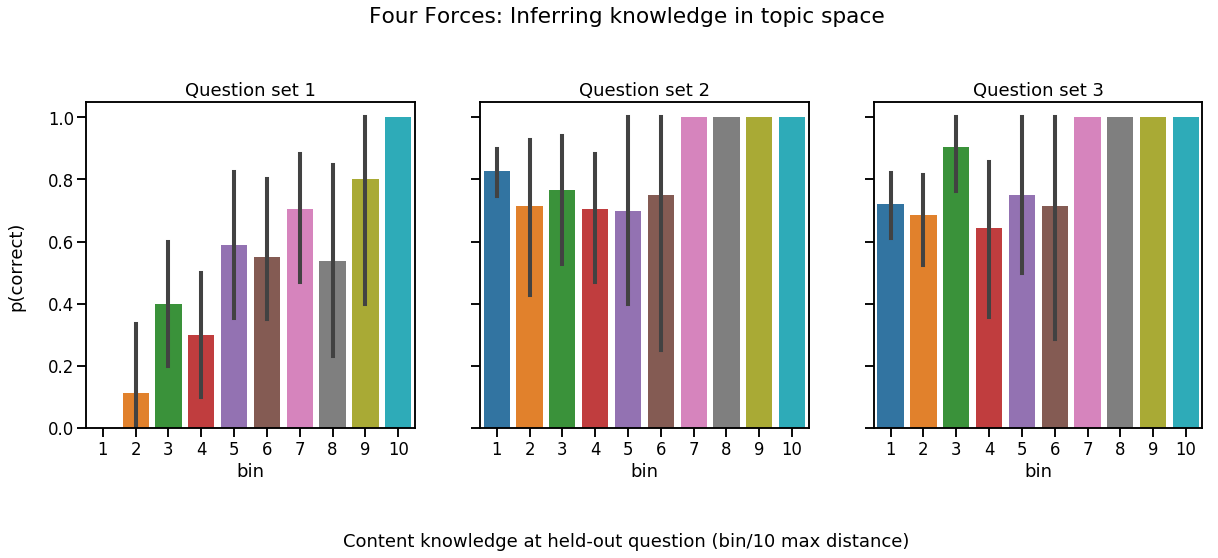

In [445]:
n_bins = 10

fig, axarr = plt.subplots(1,3, sharey=True)
fig.set_size_inches(20,6)
axarr = axarr.flatten()

for (ix, ax), qset in zip(enumerate(axarr), [qdrop_ftraces_set0, qdrop_ftraces_set1, qdrop_ftraces_set2]):
    
    learn_dists = []
    acc = []

    # get distances and accuracy
    for subdata in qset.values():
        for qdata in subdata.values():
            learn_dists.append(qdata['learn_dist'])
            acc.append(qdata['correct'])

    # set bin ranges and assign
    bins = np.linspace(np.min(learn_dists), np.max(learn_dists), n_bins)
    binned_df = pd.DataFrame({'dist' : learn_dists, 'p(correct answer)' : acc, 
                              'bin' : np.digitize(learn_dists, bins)})
    
    # plot
    sns.barplot(x='bin', y='p(correct answer)', data=binned_df, ax=ax)
    ax.set_ylabel('')
    ax.set_title(f'Question set {ix+1}')

fig.suptitle('Four Forces: Inferring knowledge in topic space', y=1.1)
fig.text(0.07, 0.5, 'p(correct)', va='center', rotation='vertical')
fig.text(0.5, -.15, 'Content knowledge at held-out question (bin/10 max distance)', ha='center')
# plt.savefig('/Users/paxtonfitzpatrick/Desktop/forces-trace-qdrop-dist.pdf', bbox_inches='tight')
plt.show()


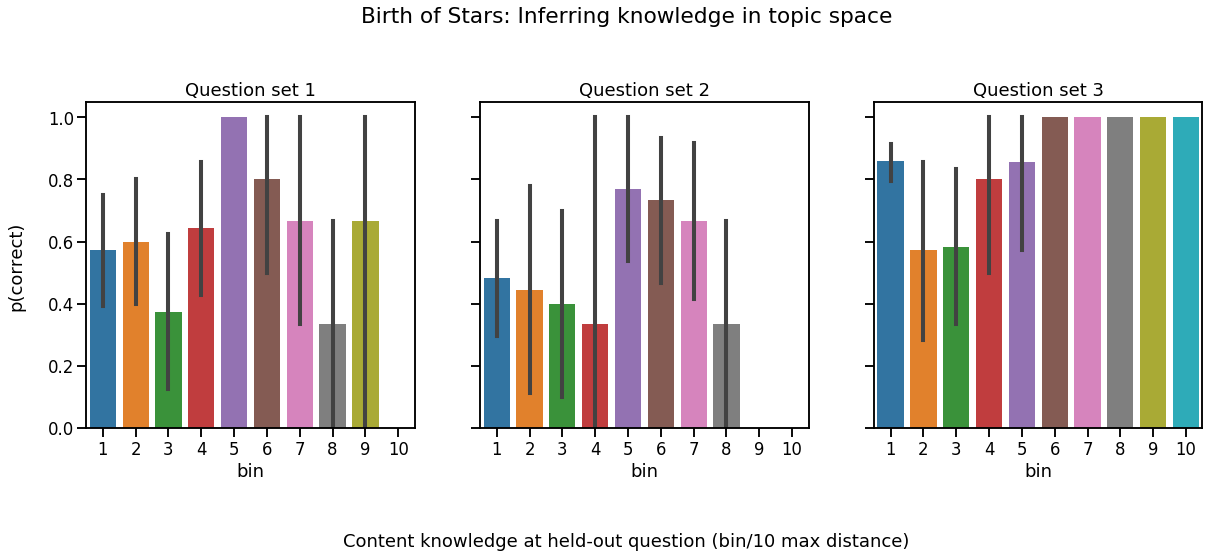

In [446]:
n_bins = 10

fig, axarr = plt.subplots(1,3, sharey=True)
fig.set_size_inches(20,6)
axarr = axarr.flatten()

for (ix, ax), qset in zip(enumerate(axarr), [qdrop_btraces_set0, qdrop_btraces_set1, qdrop_btraces_set2]):
    
    learn_dists = []
    acc = []

    # get distances and accuracy
    for subdata in qset.values():
        for qdata in subdata.values():
            learn_dists.append(qdata['learn_dist'])
            acc.append(qdata['correct'])

    # set bin ranges and assign
    bins = np.linspace(np.min(learn_dists), np.max(learn_dists), n_bins)
    binned_df = pd.DataFrame({'dist' : learn_dists, 'p(correct answer)' : acc, 
                              'bin' : np.digitize(learn_dists, bins)})
    
    # plot
    sns.barplot(x='bin', y='p(correct answer)', data=binned_df, ax=ax)
    ax.set_ylabel('')
    ax.set_title(f'Question set {ix+1}')
    
fig.suptitle('Birth of Stars: Inferring knowledge in topic space', y=1.1)
fig.text(0.07, 0.5, 'p(correct)', va='center', rotation='vertical')
fig.text(0.5, -.15, 'Content knowledge at held-out question (bin/10 max distance)', ha='center')
# plt.savefig('/Users/paxtonfitzpatrick/Desktop/bos-trace-qdrop-dist.pdf', bbox_inches='tight')
plt.show()


# construct lecture 2 learning trajectories using lecture 1 questions

In [240]:
qdrop_crosstraces_set0 = {}
qdrop_crosstraces_set1 = {}
qdrop_crosstraces_set2 = {}


for set_n, setdict in zip(range(3), [qdrop_crosstraces_set0, qdrop_crosstraces_set1, qdrop_crosstraces_set2]):
    drops = []
    for sid, df in sub_data.items():
        # get questions about Four Forces viewed in block 
        set_fqs = df.loc[df.set == set_n].loc[df.video == 1]
        setdict[f'sub{sid}'] = dict.fromkeys([f'q{i}' for i in set_fqs.qID])
    
        for q in set_fqs.qID:
            setdict[f'sub{sid}'][f'q{q}'] = {}
            # drop a question
            ix = set_fqs.loc[set_fqs.qID == q].index
            q_dropped = set_fqs.drop(ix)
            
            # extract remaining questions' topic vectors by index
            q_dropped_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in q_dropped.qID]]
            
            # get accuracy for remaining questions
            q_dropped_acc = q_dropped['correct?']

            # construct lecture 2 trace with question held out
            q_dropped_trace = reconstruct_trace(bos_v_traj, q_dropped_vecs, q_dropped_acc)
            setdict[f'sub{sid}'][f'q{q}']['trajectory'] = q_dropped_trace
            
            # get accuracy for held-out question
            setdict[f'sub{sid}'][f'q{q}']['correct'] = set_fqs.loc[ix, 'correct?'].values[0]
            
            # find distance between lecture and knowledge trajectories at nearest lecture point to question
            nearest_ix = cdist(forces_v_traj, np.atleast_2d(forces_q_traj[q-1])).argmin()
            setdict[f'sub{sid}'][f'q{q}']['learn_dist'] = np.diag(cdist(forces_v_traj, q_dropped_trace))[nearest_ix]
            
            # find distance from held-out question to nearest other question
            qq_dists = cdist(forces_q_traj, forces_q_traj)[q-1]
            setdict[f'sub{sid}'][f'q{q}']['qnear_dist'] = qq_dists[np.nonzero(qq_dists)].min()
            
            # track participants with 4/5 wrong answers (can't construct trajectory)
            if not np.any(q_dropped_trace):
                drops.append(f'sub{sid}')
    
    for sid in list(set(drops)):
        del setdict[sid]
                

In [224]:
# qdrop_btraces_set0 = {}
# qdrop_btraces_set1 = {}
# qdrop_btraces_set2 = {}


# for set_n, setdict in zip(range(3), [qdrop_btraces_set0, qdrop_btraces_set1, qdrop_btraces_set2]):
#     drops = []
#     for sid, df in sub_data.items():
#         # get questions about Birth of Stars viewed in block 
#         set_bqs = df.loc[df.set == set_n].loc[df.video == 2]
#         setdict[f'sub{sid}'] = dict.fromkeys([f'q{i}' for i in set_bqs.qID])
    
#         for q in set_bqs.qID:
#             setdict[f'sub{sid}'][f'q{q}'] = {}
#             # drop a question
#             ix = set_bqs.loc[set_bqs.qID == q].index
#             q_dropped = set_bqs.drop(ix)
            
#             # extract remaining questions' topic vectors by index
#             q_dropped_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in q_dropped.qID]]
            
#             # get accuracy for remaining questions
#             q_dropped_acc = q_dropped['correct?']

#             # construct trace with question held out
#             q_dropped_trace = reconstruct_trace(bos_v_traj, q_dropped_vecs, q_dropped_acc)
#             setdict[f'sub{sid}'][f'q{q}']['trajectory'] = q_dropped_trace
            
#             # get accuracy for held-out question
#             setdict[f'sub{sid}'][f'q{q}']['correct'] = set_bqs.loc[ix, 'correct?'].values[0]
            
#             # find distance between lecture and knowledge trajectories at nearest lecture point to question
#             nearest_ix = cdist(bos_v_traj, np.atleast_2d(bos_q_traj[q-16])).argmin()
#             setdict[f'sub{sid}'][f'q{q}']['learn_dist'] = np.diag(cdist(bos_v_traj, q_dropped_trace))[nearest_ix]
            
#             # find distance from held-out question to nearest other question
#             qq_dists = cdist(bos_q_traj, bos_q_traj)[q-16]
#             setdict[f'sub{sid}'][f'q{q}']['qnear_dist'] = qq_dists[np.nonzero(qq_dists)].min()
            
#             # track participants with 4/5 wrong answers (can't construct trajectory)
#             if not np.any(q_dropped_trace):
#                 drops.append(f'sub{sid}')
    
#     for sid in list(set(drops)):
#         del setdict[sid]
                

# given a knowledge trajectory constructed from certain questions, how well can we infer knowledge about other questions based on their distance?

In [545]:
forces_traces_set0 = {}
forces_traces_set1 = {}
forces_traces_set2 = {}


both_q_traj = np.append(forces_q_traj, bos_q_traj, axis=0)
all_q_traj = np.append(both_q_traj, general_q_traj, axis=0)

for sid, df in sub_data.items():
    forces_traces_set0[sid] = {}
    # get questions about Four Forces viewed in first block 
    set0_fqs = df.loc[df.set == 0].loc[df.video == 1]
    # extract their topic vectors by index
    set0_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set0_fqs.qID]]
    # get accuracy for those questions
    set0_fqs_acc = set0_fqs['correct?']
    sub_trace = reconstruct_trace(forces_v_traj, set0_fqs_vecs, set0_fqs_acc)
    forces_traces_set0[sid]['trajectory'] = sub_trace
    set0_nonfqs = df.loc[df.set == 0].loc[df.video ==2]
    forces_traces_set0[sid]['other_qs'] = {} #dict.fromkeys(set0_nonfqs.qID)
    for _, question in set0_nonfqs.iterrows():
        forces_traces_set0[sid]['other_qs'][question.qID] = {}
        nearest_ix = cdist(forces_v_traj, np.atleast_2d(all_q_traj[question.qID-1])).argmin()
        forces_traces_set0[sid]['other_qs'][question.qID]['learn_dist'] = np.diag(
            cdist(forces_v_traj, sub_trace))[nearest_ix]
        forces_traces_set0[sid]['other_qs'][question.qID]['acc'] = question['correct?']
        
    forces_traces_set1[sid] = {}
    # get questions about Four Forces viewed in second block 
    set1_fqs = df.loc[df.set == 1].loc[df.video == 1]
    # extract their topic vectors by index
    set1_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set1_fqs.qID]]
    # get accuracy for those questions
    set1_fqs_acc = set1_fqs['correct?']
    sub_trace = reconstruct_trace(forces_v_traj, set1_fqs_vecs, set1_fqs_acc)
    forces_traces_set1[sid]['trajectory'] = sub_trace
    set1_nonfqs = df.loc[df.set == 1].loc[df.video ==2]
    forces_traces_set1[sid]['other_qs'] = {} #dict.fromkeys(set0_nonfqs.qID)
    for _, question in set1_nonfqs.iterrows():
        forces_traces_set1[sid]['other_qs'][question.qID] = {}
        nearest_ix = cdist(forces_v_traj, np.atleast_2d(all_q_traj[question.qID-1])).argmin()
        forces_traces_set1[sid]['other_qs'][question.qID]['learn_dist'] = np.diag(
            cdist(forces_v_traj, sub_trace))[nearest_ix]
        forces_traces_set1[sid]['other_qs'][question.qID]['acc'] = question['correct?']
    
    forces_traces_set2[sid] = {}
    # get questions about Four Forces viewed in third block 
    set2_fqs = df.loc[df.set == 2].loc[df.video == 1]
    # extract their topic vectors by index
    set2_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set2_fqs.qID]]
    # get accuracy for those questions
    set2_fqs_acc = set2_fqs['correct?']
    sub_trace = reconstruct_trace(forces_v_traj, set2_fqs_vecs, set2_fqs_acc)
    forces_traces_set2[sid]['trajectory'] = sub_trace
    set2_nonfqs = df.loc[df.set == 2].loc[df.video ==2]
    forces_traces_set2[sid]['other_qs'] = {} #dict.fromkeys(set0_nonfqs.qID)
    for _, question in set2_nonfqs.iterrows():
        forces_traces_set2[sid]['other_qs'][question.qID] = {}
        nearest_ix = cdist(forces_v_traj, np.atleast_2d(all_q_traj[question.qID-1])).argmin()
        forces_traces_set2[sid]['other_qs'][question.qID]['learn_dist'] = np.diag(
            cdist(forces_v_traj, sub_trace))[nearest_ix]
        forces_traces_set2[sid]['other_qs'][question.qID]['acc'] = question['correct?']
    

In [556]:
set0_qs_acc = dict.fromkeys(question_dict.keys())
set0_qs_dists = dict.fromkeys(question_dict.keys())

set1_qs_acc = dict.fromkeys(question_dict.keys())
set1_qs_dists = dict.fromkeys(question_dict.keys())

set2_qs_acc = dict.fromkeys(question_dict.keys())
set2_qs_dists = dict.fromkeys(question_dict.keys())

for q in question_dict.keys():
    accs = []
    dists = []
    for sub, sdata in forces_traces_set0.items():
        for question, qdata in sdata['other_qs'].items():
            if question == q:
                accs.append(qdata['acc'])
                dists.append(qdata['learn_dist'])
    set0_qs_acc[q] = accs
    set0_qs_dists[q] = dists
for q in list(set0_qs_acc.keys()):
    if not set0_qs_acc[q]:
        del set0_qs_acc[q]
        del set0_qs_dists[q]
        
for q in question_dict.keys():
    accs = []
    dists = []
    for sub, sdata in forces_traces_set1.items():
        for question, qdata in sdata['other_qs'].items():
            if question == q:
                accs.append(qdata['acc'])
                dists.append(qdata['learn_dist'])
    set1_qs_acc[q] = accs
    set1_qs_dists[q] = dists
for q in list(set1_qs_acc.keys()):
    if not set1_qs_acc[q]:
        del set1_qs_acc[q]
        del set1_qs_dists[q]
        
for q in question_dict.keys():
    accs = []
    dists = []
    for sub, sdata in forces_traces_set2.items():
        for question, qdata in sdata['other_qs'].items():
            if question == q:
                accs.append(qdata['acc'])
                dists.append(qdata['learn_dist'])
    set2_qs_acc[q] = accs
    set2_qs_dists[q] = dists
for q in list(set2_qs_acc.keys()):
    if not set2_qs_acc[q]:
        del set2_qs_acc[q]
        del set2_qs_dists[q]

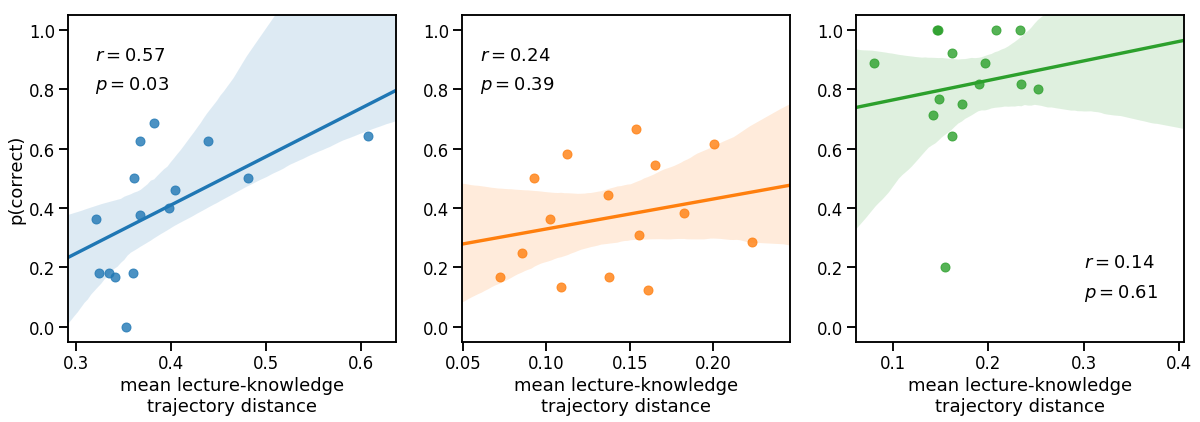

In [577]:
fig, axarr = plt.subplots(1,3)
fig.set_size_inches(20, 6)
axarr = axarr.flatten()

sns.regplot([np.mean(v) for v in set0_qs_dists.values()], [np.mean(v) for v in set0_qs_acc.values()], ax=axarr[0])
axarr[0].set_xlabel('mean lecture-knowledge\ntrajectory distance')
axarr[0].set_ylabel('p(correct)')
axarr[0].set_ylim(-.05, 1.05)
r, p = pearsonr([np.mean(v) for v in set0_qs_dists.values()], [np.mean(v) for v in set0_qs_acc.values()])
r = '=' + str(round(r, 2))
if p >= 0.01:
    p = '=' + str(round(p, 2))
else:
    p = '<0.01'
axarr[0].text(.32, .9, f'$r{r}$')
axarr[0].text(.32, .8, f'$p{p}$')

sns.regplot([np.mean(v) for v in set1_qs_dists.values()], [np.mean(v) for v in set1_qs_acc.values()], ax=axarr[1])
axarr[1].set_xlabel('mean lecture-knowledge\ntrajectory distance')
axarr[1].set_ylim(-.05, 1.05)
r, p = pearsonr([np.mean(v) for v in set1_qs_dists.values()], [np.mean(v) for v in set1_qs_acc.values()])
r = '=' + str(round(r, 2))
if p >= 0.01:
    p = '=' + str(round(p, 2))
else:
    p = '<0.01'
axarr[1].text(.06, .9, f'$r{r}$')
axarr[1].text(.06, .8, f'$p{p}$')

sns.regplot([np.mean(v) for v in set2_qs_dists.values()], [np.mean(v) for v in set2_qs_acc.values()], ax=axarr[2])
axarr[2].set_xlabel('mean lecture-knowledge\ntrajectory distance')
axarr[2].set_ylim(-.05, 1.05)
r, p = pearsonr([np.mean(v) for v in set2_qs_dists.values()], [np.mean(v) for v in set2_qs_acc.values()])
r = '=' + str(round(r, 2))
if p >= 0.01:
    p = '=' + str(round(p, 2))
else:
    p = '<0.01'
axarr[2].text(.3, .2, f'$r{r}$')
axarr[2].text(.3, .1, f'$p{p}$')

plt.show()

In [573]:
p

'=1.0'